# 데이터 준비와 확인

In [1]:
import pandas as pd

#데이터읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터로더 구성

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
#딕셔너리에서 뽑아낸 키와 밸류 값의 위치를 바꿈
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 모델 구성을 위한 데이터 분석 및 가공

### 데이터셋 내 문장 길이 확인 및 분포

In [5]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 문장 길이: ', len(X_train[0]))
print('2번째 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 문장 길이:  10
2번째 문장 길이:  17


In [6]:
#리스트 X_train과 X_test를 더해서 total_data_text를 만듬
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


### 적절한 최대 문장 길이 지정

In [7]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(round(np.sum(num_tokens < max_tokens) / len(num_tokens)*100, 2)))

pad_sequences maxlen :  41
전체 문장의 93.43%가 maxlen 설정값 이내에 포함됩니다. 


maxlen = 41로 설정됨

#### keras.preprocessing.sequence.pad_sequences 를 활용한 패딩 추가

In [8]:
#pre 혹은 post 두 가지 제외방식이 있으나, post를 사용할경우 패드를 제거하므로 pre에 비하여 효용성이 떨어짐
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)
print(X_train.shape)

(146182, 41)


In [9]:
# 문장길이의 평균값, 최대값, 표준편차를 다시 계산
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  41.0
문장길이 최대 :  41
문장길이 표준편차 :  0.0


# 모델 구성 및 validation set 구성 + 훈련개시

### 1)RNN모델

In [10]:
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수

rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(tf.keras.layers.LSTM(32))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용. 이때 LSTM state 벡터의 차원수는 변경가능함
rnn_model.add(tf.keras.layers.Dense(12, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 12)                396       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 166,681
Trainable params: 166,681
Non-trainable params: 0
_________________________________________________________________


### RNN훈련 전 검증셋 떼어두기

In [11]:
# validation set 55,000건 분리
X_val = X_train[:55000]   
y_val = y_train[:55000]

# validation set을 제외한 나머지
partial_X_train = X_train[55000:]  
partial_y_train = y_train[55000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(91182, 41)
(91182,)


# RNN훈련

In [12]:
rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = rnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
179/179 [==============================] - 5s 9ms/step - loss: 0.5102 - accuracy: 0.7582 - val_loss: 0.3692 - val_accuracy: 0.8408
Epoch 2/20
179/179 [==============================] - 1s 6ms/step - loss: 0.3446 - accuracy: 0.8537 - val_loss: 0.3502 - val_accuracy: 0.8491
Epoch 3/20
179/179 [==============================] - 1s 6ms/step - loss: 0.3161 - accuracy: 0.8680 - val_loss: 0.3490 - val_accuracy: 0.8482
Epoch 4/20
179/179 [==============================] - 1s 6ms/step - loss: 0.3011 - accuracy: 0.8759 - val_loss: 0.3535 - val_accuracy: 0.8491
Epoch 5/20
179/179 [==============================] - 1s 7ms/step - loss: 0.2881 - accuracy: 0.8811 - val_loss: 0.3585 - val_accuracy: 0.8468
Epoch 6/20
179/179 [==============================] - 1s 7ms/step - loss: 0.2752 - accuracy: 0.8880 - val_loss: 0.3568 - val_accuracy: 0.8470
Epoch 7/20
179/179 [==============================] - 1s 6ms/step - loss: 0.2616 - accuracy: 0.8944 - val_loss: 0.3613 - val_accuracy: 0.8456
Epoch 

### RNN평가

In [13]:
results = rnn_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6385 - accuracy: 0.8263
[0.6384586095809937, 0.8263319730758667]


### RNN 그래프

In [14]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


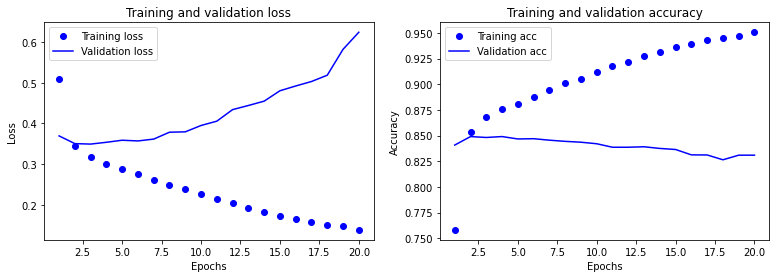

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1) #acc는 history값 , 에포치를 20으로 설정하였을 때의 값이 저장됨

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
# bo는 점선
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 파란 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.5,1)
plt.legend()

plt.show()

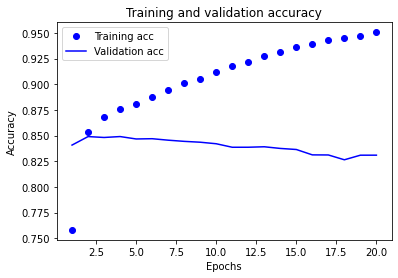

In [16]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 2) 1-D Convolution Neural Network(1-D CNN)

In [17]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(keras.layers.MaxPooling1D(5))
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(keras.layers.GlobalMaxPooling1D())
cnn_model.add(keras.layers.Dense(8, activation='relu'))
cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### 1-D CNN훈련

In [18]:
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

cnn_history = cnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)



Epoch 1/20
179/179 [==============================] - 3s 7ms/step - loss: 0.5381 - accuracy: 0.7147 - val_loss: 0.3672 - val_accuracy: 0.8383
Epoch 2/20
179/179 [==============================] - 1s 5ms/step - loss: 0.3409 - accuracy: 0.8539 - val_loss: 0.3498 - val_accuracy: 0.8472
Epoch 3/20
179/179 [==============================] - 1s 5ms/step - loss: 0.3030 - accuracy: 0.8736 - val_loss: 0.3486 - val_accuracy: 0.8493
Epoch 4/20
179/179 [==============================] - 1s 5ms/step - loss: 0.2759 - accuracy: 0.8875 - val_loss: 0.3485 - val_accuracy: 0.8500
Epoch 5/20
179/179 [==============================] - 1s 5ms/step - loss: 0.2489 - accuracy: 0.9014 - val_loss: 0.3580 - val_accuracy: 0.8494
Epoch 6/20
179/179 [==============================] - 1s 5ms/step - loss: 0.2198 - accuracy: 0.9161 - val_loss: 0.3833 - val_accuracy: 0.8447
Epoch 7/20
179/179 [==============================] - 1s 5ms/step - loss: 0.1881 - accuracy: 0.9314 - val_loss: 0.4013 - val_accuracy: 0.8439
Epoch 

### 1-D CNN평가

In [19]:
results = cnn_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 1.0056 - accuracy: 0.8104
[1.0055862665176392, 0.8103830814361572]


### 1-D CNN 그래프

In [20]:
cnn_history_dict = cnn_history.history
print(cnn_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


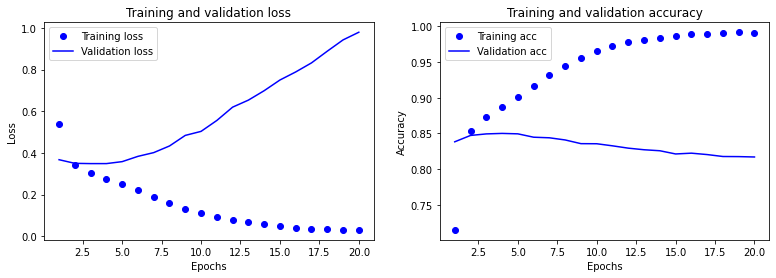

In [21]:
acc = cnn_history_dict['accuracy']
val_acc = cnn_history_dict['val_accuracy']
loss = cnn_history_dict['loss']
val_loss = cnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.5,1)
plt.legend()

plt.show()

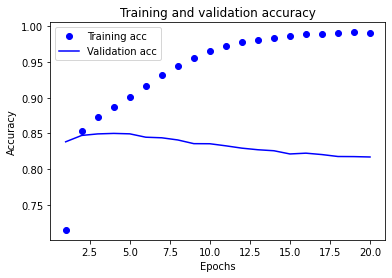

In [22]:
plt.clf()   # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 3)GlobalMaxPooling1D

In [23]:
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

gmp_model = tf.keras.Sequential()
gmp_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp_model.add(tf.keras.layers.GlobalMaxPooling1D())
gmp_model.add(tf.keras.layers.Dense(64, activation='relu'))
gmp_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 161,153
Trainable params: 161,153
Non-trainable params: 0
_________________________________________________________________


### GlobalMaxPooling1D훈련

In [24]:
gmp_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history3 = gmp_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
179/179 [==============================] - 1s 5ms/step - loss: 0.5592 - accuracy: 0.7542 - val_loss: 0.3907 - val_accuracy: 0.8275
Epoch 2/20
179/179 [==============================] - 1s 4ms/step - loss: 0.3549 - accuracy: 0.8460 - val_loss: 0.3581 - val_accuracy: 0.8417
Epoch 3/20
179/179 [==============================] - 1s 4ms/step - loss: 0.3083 - accuracy: 0.8710 - val_loss: 0.3554 - val_accuracy: 0.8430
Epoch 4/20
179/179 [==============================] - 1s 4ms/step - loss: 0.2777 - accuracy: 0.8860 - val_loss: 0.3629 - val_accuracy: 0.8440
Epoch 5/20
179/179 [==============================] - 1s 4ms/step - loss: 0.2539 - accuracy: 0.8976 - val_loss: 0.3747 - val_accuracy: 0.8446
Epoch 6/20
179/179 [==============================] - 1s 4ms/step - loss: 0.2335 - accuracy: 0.9072 - val_loss: 0.3892 - val_accuracy: 0.8415
Epoch 7/20
179/179 [==============================] - 1s 4ms/step - loss: 0.2159 - accuracy: 0.9162 - val_loss: 0.4074 - val_accuracy: 0.8383
Epoch 

### GlobalMaxPooling1D평가

In [25]:
results = gmp_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6496 - accuracy: 0.8145
[0.6495944857597351, 0.8144720196723938]


### GlobalMaxPooling1D그래프

In [26]:
history_dict3 = history3.history
print(history_dict3.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


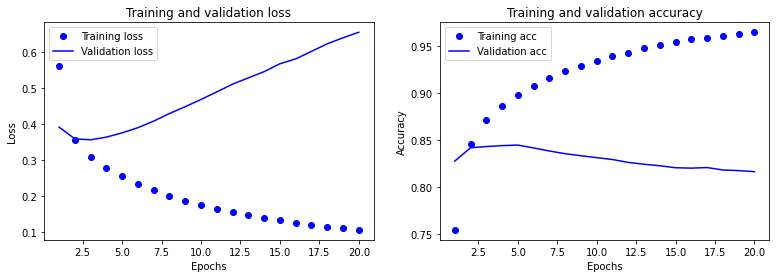

In [27]:
acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.5,1)
plt.legend()

plt.show()

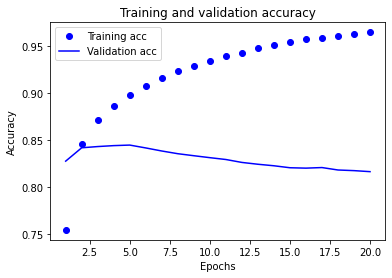

In [28]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [29]:
embedding_layer = gmp_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [30]:
import os

# 학습한 Embedding 파라미터를 파일에 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록 
vectors = gmp_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.17715299, -0.18704416, -0.1697652 , -0.24550137,  0.0212128 ,
       -0.14738311, -0.01667253, -0.15847516,  0.02442241,  0.04597521,
       -0.05196406, -0.05876683, -0.08308861, -0.07014778,  0.10487927,
       -0.03040944], dtype=float32)

In [32]:
word_vectors.similar_by_word("재미")

[('만큼', 0.8494948148727417),
 ('풀어내', 0.8401104211807251),
 ('어찌', 0.8301867842674255),
 ('재', 0.8155735731124878),
 ('는대', 0.7988385558128357),
 ('셀', 0.7811558842658997),
 ('다름', 0.7806766033172607),
 ('티비', 0.779503345489502),
 ('크리스마스', 0.7717375159263611),
 ('땐', 0.7711017727851868)]

# Word2Vec 임베딩 활용하여 성능개선

In [33]:
from gensim.models import KeyedVectors
import gensim
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin.gz'
#word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['재미']
vector

/tmp/ipykernel_18418/367809073.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['재미']


array([-0.01228145, -0.4937083 ,  0.4424771 , -1.0789338 , -1.0551587 ,
       -0.8106456 , -0.0881472 ,  0.7738013 , -0.3837249 , -0.31405708,
        0.18792619, -0.04978764,  0.3977235 ,  1.0052139 , -0.5921918 ,
        0.57315415, -0.13287784,  1.4190367 ,  0.5338879 ,  0.08187074,
       -0.21017547, -0.31960285,  0.08991678, -0.06743078,  0.14399454,
        0.04861213,  0.4904712 ,  0.38203648, -0.33213428, -0.48618734,
       -0.6996383 , -0.48903087, -0.5666092 ,  0.11454912,  0.7527777 ,
       -1.6491356 ,  0.709264  ,  0.14231981,  1.2408166 ,  0.9104645 ,
        1.0235597 , -0.7135743 , -0.5323588 , -0.16439462, -0.12318534,
       -0.41341293,  0.76286334, -0.24337888, -1.0924134 , -0.78981435,
        0.24504295, -0.472915  , -0.17546178,  0.10006592, -1.2155428 ,
        0.4059387 ,  0.8259838 , -0.18593056, -0.21122731, -0.46615708,
        0.74433243, -0.18605745, -0.9175297 ,  0.08531424,  0.09134697,
       -0.60375917,  0.5236646 ,  0.7689134 ,  0.19123535,  0.60

In [34]:
word2vec.similar_by_word("재미")

/tmp/ipykernel_18418/2795643307.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("재미")


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [35]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_18418/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_18418/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [36]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
gmp_model = tf.keras.Sequential()
gmp_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
gmp_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
gmp_model.add(tf.keras.layers.MaxPooling1D(5))
gmp_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
gmp_model.add(tf.keras.layers.GlobalMaxPooling1D())
gmp_model.add(tf.keras.layers.Dense(8, activation='relu'))
gmp_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

gmp_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [37]:
gmp_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  #

history = gmp_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
179/179 [==============================] - 2s 9ms/step - loss: 0.5663 - accuracy: 0.6940 - val_loss: 0.4678 - val_accuracy: 0.7802
Epoch 2/20
179/179 [==============================] - 1s 7ms/step - loss: 0.4186 - accuracy: 0.8096 - val_loss: 0.4000 - val_accuracy: 0.8213
Epoch 3/20
179/179 [==============================] - 1s 7ms/step - loss: 0.3477 - accuracy: 0.8493 - val_loss: 0.3789 - val_accuracy: 0.8325
Epoch 4/20
179/179 [==============================] - 1s 7ms/step - loss: 0.3047 - accuracy: 0.8723 - val_loss: 0.3714 - val_accuracy: 0.8386
Epoch 5/20
179/179 [==============================] - 1s 7ms/step - loss: 0.2713 - accuracy: 0.8897 - val_loss: 0.3734 - val_accuracy: 0.8400
Epoch 6/20
179/179 [==============================] - 1s 7ms/step - loss: 0.2433 - accuracy: 0.9031 - val_loss: 0.3964 - val_accuracy: 0.8365
Epoch 7/20
179/179 [==============================] - 1s 7ms/step - loss: 0.2176 - accuracy: 0.9156 - val_loss: 0.4138 - val_accuracy: 0.8378
Epoch 

In [38]:
results = gmp_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9567 - accuracy: 0.8151
[0.9566640257835388, 0.815082311630249]


결과적으로 0.0006의 정확도 향상이 있었습니다.
문자열을 출력을 했을 때 개선이 많이 된 것이 체감이 되지만, 정확도는 아주 미미한 향상이 있었습니다.
하이퍼 파라미터를 잘못 설정한 것일수도, 모델을 잘못 설계했을 가능성도 있습니다.

혹시나해서 다른 수치로 바꿔봤지만, 임베딩을 했을 때 감소하는 경우가 생각보다 많아서 최적의 조합을 찾지 못하였습니다.

